In [6]:

"""
This script takes candidate mutation table from snakemake pipeline as input and does a lot of downstream analysis
"""
import numpy as np
import pickle
import math
import pandas as pd
import sys
sys.path.insert(0, './miniscripts_for_dNdS')
import os
import re
import copy
import argparse
from scipy import stats

import traceback
# Import Lieberman Lab SNV-calling python package
#script_dir = os.path.dirname(os.path.abspath(__file__))
script_dir = os.getcwd()
dir_py_scripts = script_dir+"/modules"
sys.path.insert(0, dir_py_scripts)
import snv_module_recoded_with_dNdS_test as snv
import build_SNP_Tree as bst

# ---------------------------------------------------------------------------
# Variables for interactive use
# ---------------------------------------------------------------------------
# When running this script in an interactive environment (e.g. Spyder or
# Jupyter), set ``ref_dir`` to the directory containing ``genome.fasta``
# and ``input_mat`` to the path of your candidate mutation table (NPZ file).
# ``output_dir`` determines where results will be written.

# The parameters below control manual filtering behaviour:
#   - ``fn_min_cov``: minimum forward+reverse reads required per sample
#     (default 1).
#   - ``fn_min_qual``: minimum quality score per sample (default 30).
#   - ``fn_min_freq``: minimum major allele frequency per sample
#     (default 0.75).
#   - ``max_indel``: maximum fraction of reads supporting
#     an indel in a sample (turned off by default; reference ``-d 0.33``).
#   - ``min_freq``: across samples, maximum fraction of
#     undefined bases per position (turned off by default; reference
#     ``-g 0.25``).
#   - ``min_med_cov``: minimum median coverage across samples
#     per position (turned off by default; reference ``-m 5``).
#   - ``eb``: set to ``1`` to exclude SNVs from potential
#     recombination events (default includes them).
# Leave these as ``None`` to use the script defaults, or assign values (e.g.
# ``0.75``) to experiment interactively.

ref_dir = "../snake_pipeline/reference_genomes/Cae_ref"
ref_genome_name = search_ref_name(ref_dir)
input_mat = "test_data/candidate_mutation_table_final.npz"
output_dir = "accusnv_downstream_out"
fn_min_cov = 1           # default 1
fn_min_qual = 30        # default 30
fn_min_freq = 0.75        # default 0.75
max_indel = None # e.g. 0.33
min_freq = None   # e.g. 0.25
min_med_cov = None    # e.g. 5
eb = 0            # set to 1 to exclude recombination sites

# ---------------------------------------------------------------------------


# parser=argparse.ArgumentParser(prog='Downstream analysis module of AccuSNV',description='SNV calling tool for bacterial isolates using deep learning.')
# parser.add_argument('-i','--input_mat',dest='input_mat',type=str,default=mut_table,help="The input mutation table in npz file")
# #parser.add_argument('-t','--input_report',dest='input_report',type=str,required=True,help="The input of the full annotation dataframe (snv_table_merge_all_mut_annotations.tsv) output by accusnv_snakemake")
# parser.add_argument('-r','--ref_dir',dest='ref_dir',default=ref_genome,type=str,help="The dir of your reference genomes")
# 
# # Manual filtering parameters - used for fill-N modules for individual samples. (Decide whether the base of the specific sample shown as 'N' or the 'ATGC')
# parser.add_argument('-c','--min_cov_for_call',dest='min_cov',type=int,default=min_cov_for_call,help="For the fill-N module: on individual samples, calls must have at least this many fwd+rev reads. Default is 1.")
# parser.add_argument('-q','--min_qual_for_call',dest='min_qual',type=int,default=min_qual_for_call,help="For the fill-N module: on individual samples, calls must have at least this minimum quality score. Default is 30.")
# parser.add_argument('-f','--min_freq_for_call',dest='min_freq',type=str,default=min_freq_for_call,help="For the fill-N module: on individual samples, a call's major allele must have at least this freq. Default is 0.75.")
# 
# # Three new manual filtering parameters for further filtering identified SNVs, updated on 2025-05-23 - There parameters are turned off by default.
# parser.add_argument('-d','--max_frac_reads_supporting_indel',dest='max_indel',default=max_frac_reads_supporting_indel,type=float,help="For the manual filtering module: on individual samples, no more than this fraction of reads can support an indel at any given position. (Default: turn off, referece value: -d 0.33)")
# parser.add_argument('-g','--max_fraction_ambigious_samples',dest='max_ambig',default=max_fraction_ambigious_samples,type=float,help="For the manual filtering module: across samples per position, the fraction of samples that can have undefined bases. (Default: turn off, referece value: -g 0.25)")
# parser.add_argument('-m','--min_median_coverage_position',dest='min_med_cov',default=min_median_coverage_position,type=int,help="For the manual filtering module:across samples per position, the median coverage. (Default: turn off, referece value: -m 5)")
# #parser.add_argument('-p','--max_mean_copynum',dest='max_mean_cp',type=int,help="Mean copy number at a positions across all samples. (Default: turn off, referece value: -p 4)")
# #parser.add_argument('-x','--max_max_copynum',dest='max_max_cp',type=int,help="Max maximum copynumber that a site can have across all samples. (Default: turn off, referece value: -x 7)")
# 
# parser.add_argument('-b','--exclude_recomb',dest='exclude_recomb',type=int,default=exclude_recomb,help="Whether included SNVs from potential recombinations. Default included. Set \"-b 1\" to exclude these positions in downstream analysis modules.")
# 
# parser.add_argument('-o','--output_dir',dest='output_dir',type=str,default=output_dir_default,help="The output dir")
# args = parser.parse_args()

def set_para_int(invalue,expect):
    if not invalue:
        invalue=expect
    else:
        invalue=int(invalue)
    return invalue

def set_para_float(invalue,expect):
    if not invalue:
        invalue=expect
    else:
        invalue=float(invalue)
    return invalue

def search_ref_name(refg):
    pre=''
    #fname=''
    for filename in os.listdir(refg):
        if re.search('fa',filename) or re.search('fna',filename):
            pre=re.split('\.',filename)[0]

            break
    return pre

# input_mat=args.input_mat
# #input_report=args.input_report
# ref_dir=args.ref_dir
# ref_genome_name = search_ref_name(ref_dir)
# fn_min_cov=args.min_cov
# fn_min_qual=args.min_qual
# fn_min_freq=float(args.min_freq)
# max_indel=args.max_indel
# min_freq=args.max_ambig
# min_med_cov=args.min_med_cov
# 
# 
# eb=args.exclude_recomb
# output_dir=args.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# fn_min_cov=set_para_int(fn_min_cov,1)
# fn_min_qual=set_para_int(fn_min_qual,30)
# fn_min_freq=set_para_float(fn_min_freq,0.75)
# eb=set_para_int(eb,0)



[quals,p,counts,in_outgroup,sample_names,indel_counter] = \
    snv.read_candidate_mutation_table_npz(input_mat)

my_cmt = snv.cmt_data_object( sample_names,
                             in_outgroup,
                             p,
                             counts,
                             quals,
                             indel_counter
                             )

#print(my_cmt.counts)
#exit()
with open(input_mat, 'rb') as f:
    cmt = np.load(f)
    prob = np.array(cmt['prob'])
    label = np.array(cmt['label'])
    recomb = np.array(cmt['recomb'])

# by default - will use label=1 positions
filt_pos= label
filt_pos2 = ~recomb
#print(len(filt_pos))
#print(len(filt_pos2))
#filt_pos=np.array(filt_pos)
#print(my_cmt.p.shape)
#print(filt_pos2)
if eb==1:
    filt_pos=filt_pos & filt_pos2
#print(filt_pos)
#exit()
my_cmt.filter_positions(filt_pos)
#my_cmt.filter_positions(filt_pos2)
my_calls = snv.calls_object( my_cmt )
my_rg = snv.reference_genome_object( ref_dir )
my_rg_annot = my_rg.annotations
#exit()
# Track filter results
dlab = dict(zip(my_cmt.p, label[filt_pos].astype(int)))
dprob = dict(zip(my_cmt.p, prob[filt_pos]))
#print(dlab,dprob)
#exit()
recombo_bool = recomb[filt_pos]
dpt = {'recomb': dict(zip(my_cmt.p, recombo_bool))}




# Apply looser filters than before (want as many alleles as possible)



'''
Fill-N module: fill N for samples with a loose filter cutoff
'''
# Remove sites within samples that are not high quality
filter_parameter_calls_for_tree = {
                                    'min_cov_for_call' : fn_min_cov, # on individual samples, calls must have at least this many fwd+rev reads
                                    'min_qual_for_call' : fn_min_qual, # on individual samples, calls must have this minimum quality score
                                    'min_major_nt_freq_for_call' : fn_min_freq,  # on individual samples, a call's major allele must have at least this freq
                                    'max_frac_reads_supporting_indel' : max_indel   # on individual samples, no more than this fraction of reads can support an indel at any given position
                                    }

'''
Manual filtering module: filter SNVs using filtering cutoff (same as those in WideVariant)
'''
# Remove sites across samples that are not high quality
filter_parameter_site_across_samples = {
                                        'max_fraction_ambigious_samples' : min_freq, # across samples per position, the fraction of samples that can have undefined bases # default: 1
                                        'min_median_coverage_position' : min_med_cov, # across samples per position, the median coverage # default: 5
                                        }
'''
Fill-N module
'''
#my_calls_raw = copy.deepcopy(my_calls)
my_calls.filter_calls_by_element(
    my_cmt.coverage < filter_parameter_calls_for_tree['min_cov_for_call']
    ) # forward strand coverage too low
#tokens = snv.token_generate(my_calls_raw.calls.T, my_calls.calls.T, 'filter-coverage-'+str(filter_parameter_calls_for_tree['min_cov_for_call']))
#dpt['cov'] = dict(zip(my_calls.p, tokens))

my_calls_raw = copy.deepcopy(my_calls)
my_calls.filter_calls_by_element(
    my_cmt.quals < filter_parameter_calls_for_tree['min_qual_for_call']
    ) # quality too low
tokens = snv.token_generate(my_calls_raw.calls.T, my_calls.calls.T, 'filter-qual')
dpt['qual'] = dict(zip(my_calls.p, tokens))

my_calls_raw = copy.deepcopy(my_calls)
my_calls.filter_calls_by_element(
    my_cmt.major_nt_freq < filter_parameter_calls_for_tree['min_major_nt_freq_for_call']
    ) # major allele frequency too low
tokens = snv.token_generate(my_calls_raw.calls.T, my_calls.calls.T, 'filter-major allele freq')
dpt['maf'] = dict(zip(my_calls.p, tokens))

'''
Manual filtering module
'''

#print(my_cmt.fwd_cov)
#print(filter_parameter_calls_for_tree['min_cov_for_call'])
#exit()
my_calls_raw = copy.deepcopy(my_calls)
my_calls.filter_calls_by_element(
    my_cmt.fwd_cov < filter_parameter_calls_for_tree['min_cov_for_call']
    ) # forward strand coverage too low

my_calls.filter_calls_by_element(
    my_cmt.rev_cov < filter_parameter_calls_for_tree['min_cov_for_call']
    ) # reverse strand coverage too low

tokens = snv.token_generate(my_calls_raw.calls.T, my_calls.calls.T, 'filter-coverage-'+str(filter_parameter_calls_for_tree['min_cov_for_call']))
dpt['cov'] = dict(zip(my_calls.p, tokens))

if max_indel:
    with np.errstate(divide='ignore', invalid='ignore'):
        # compute number of reads supporting an indel
        frac_reads_supporting_indel = np.sum(my_cmt.indel_stats,axis=2) / my_cmt.coverage  # sum reads supporting insertion plus reads supporting deletion
        frac_reads_supporting_indel[~np.isfinite(frac_reads_supporting_indel)] = 0
        # note: this fraction can be above zero beacuse the number of reads supporting an indel includes a +/-3 bp window around a given position on the genome
    my_calls_raw = copy.deepcopy(my_calls)
    my_calls.filter_calls_by_element(
        frac_reads_supporting_indel > filter_parameter_calls_for_tree['max_frac_reads_supporting_indel']
    )  # too many reads supporting indels
    tokens = snv.token_generate(my_calls_raw.calls.T, my_calls.calls.T, 'filter-indel')
    dpt['indel'] = dict(zip(my_calls.p, tokens))
    print('Indel-based filter finished.')

if min_freq:
    my_calls_raw = copy.deepcopy(my_calls)
    my_calls.filter_calls_by_position(
        my_calls.get_frac_Ns_by_position() > filter_parameter_site_across_samples['max_fraction_ambigious_samples']
    )  # too many samples with ambiuguous calls at this position
    tokens = snv.token_generate(my_calls_raw.calls.T, my_calls.calls.T, 'filter-max_fraction_ambigious_samples')
    dpt['mfas'] = dict(zip(my_calls.p, tokens))

if min_med_cov:
    my_calls_raw = copy.deepcopy(my_calls)
    my_calls.filter_calls_by_position(
        np.median(my_cmt.coverage, axis=0) < filter_parameter_site_across_samples['min_median_coverage_position']
    )  # insufficient median coverage across samples at this position
    tokens = snv.token_generate(my_calls_raw.calls.T, my_calls.calls.T, 'filter-min_median_coverage_position')
    dpt['mmcp'] = dict(zip(my_calls.p, tokens))


#exit()

#print(my_calls.calls)
#exit()
###############################################

# Filtered calls for outgroup samples only
calls_outgroup = my_calls.get_calls_in_outgroup_only()
# Switch N's (0's) to NaNs
calls_outgroup_N_as_NaN = calls_outgroup.astype('float') # init ()
calls_outgroup_N_as_NaN[ calls_outgroup_N_as_NaN==0 ] = np.nan

# Infer ancestral allele as the most common allele among outgroup samples (could be N)
calls_ancestral = np.zeros( my_calls.num_pos, dtype='int') # init as N's
outgroup_pos_with_calls = np.any(calls_outgroup,axis=0) # positions where the outgroup has calls
calls_ancestral[outgroup_pos_with_calls] = stats.mode( calls_outgroup_N_as_NaN[:,outgroup_pos_with_calls], axis=0, nan_policy='omit' ).mode.squeeze()

Number of samples in candidate mutation table: 4.
Number of genome positions in candidate mutation table: 38.
Number of positions in candidate mutation table reduced from 38 to 38.
Number of samples in calls object: 4.
Number of positions in calls object: 38.
['../snake_pipeline/reference_genomes/Cae_ref/annotations.gff']
The filter group: [ filter-qual ], total pos: 38 , how many pos already same base or filtered: 0 , how many position filtered: 0 , how many positions left: 38
The filter group: [ filter-major allele freq ], total pos: 38 , how many pos already same base or filtered: 0 , how many position filtered: 0 , how many positions left: 38
The filter group: [ filter-coverage-1 ], total pos: 38 , how many pos already same base or filtered: 0 , how many position filtered: 0 , how many positions left: 38


The filter group: [ filter-fixedmutation ], total pos: 38 , how many pos already same base or filtered: 0 , how many position filtered: 0 , how many positions left: 38
Number of positions in candidate mutation table reduced from 38 to 38.
Number of positions in candidate mutation table reduced from 38 to 38.
Number of positions in calls object reduced from 38 to 38.
Build parsimony tree...


/Users/liaoherui/Desktop/env_accusnv/local_test/AccuSNV/2025-08-03-add-new-func/AccuSNV/local_analysis/modules/build_SNP_Tree.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.rename(columns={'contig_pos': 'pos'}, inplace=True)
/Users/liaoherui/Desktop/env_accusnv/local_test/AccuSNV/2025-08-03-add-new-func/AccuSNV/local_analysis/modules/build_SNP_Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.rename(columns={'contig_idx': 'chr'}, inplace=True)


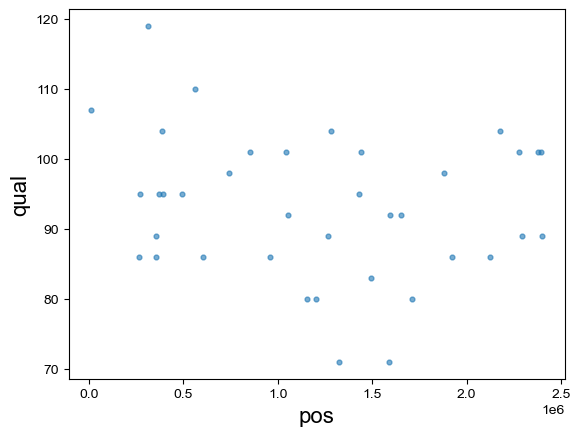

In [7]:

# Grab filtered calls from ingroup samples only
calls_ingroup = my_calls.get_calls_in_sample_subset( np.logical_not( my_calls.in_outgroup ) )
quals_ingroup = my_cmt.quals[ np.logical_not( my_calls.in_outgroup ),: ]
num_samples_ingroup = sum( np.logical_not( my_calls.in_outgroup ) )
# Note: Here we are only looking for SNV differences among ingroup samples. If
# you also want to find SNV differences between the ingroup and the outgroup
# samples (eg mutations that have fixed across the ingroup), then you need to
# use calls and quals matrices that include outgroup samples.
#print(calls_ingroup,quals_ingroup)
#exit()
# Compute quality
[ mut_qual, mut_qual_samples ] = snv.compute_mutation_quality( calls_ingroup, quals_ingroup )
# note: returns NaN if there is only one type of non-N call

# Make a table (pandas dataframe) of SNV positions and relevant annotations
# # Pull alleles from reference genome across p
calls_reference = my_rg.get_ref_NTs_as_ints( my_cmt.p )

# # Update ancestral alleles
pos_to_update = ( calls_ancestral==0 )
calls_ancestral[ pos_to_update ] = calls_reference[ pos_to_update ]
#goodpos_bool=arr = np.ones(len(my_cmt.p), dtype=bool)
#goodpos_bool = np.ones(len(my_cmt.p), dtype=bool)
#goodpos_idx = np.where( goodpos_bool )[0]

calls_goodpos_all = my_calls.calls
calls_goodpos_ingroup_all = calls_goodpos_all[ np.logical_not( my_calls.in_outgroup ),: ]
#calls_all = my_calls.calls
#calls_ingroup_all = calls_all[ np.logical_not( my_calls.in_outgroup ),: ]


# Filters
filter_SNVs_not_N = ( calls_ingroup != snv.nts2ints('N') ) # mutations must have a basecall (not N)
filter_SNVs_not_ancestral_allele = ( calls_ingroup != np.tile( calls_ancestral, (num_samples_ingroup,1) ) ) # mutations must differ from the ancestral allele

# Fixed mutations per sample per position
fixedmutation = \
    filter_SNVs_not_N \
    & filter_SNVs_not_ancestral_allele

goodpos_bool = np.any( fixedmutation, axis=0 )
goodpos_idx = np.where( goodpos_bool )[0]
tokens_final = snv.generate_tokens_last(tokens, goodpos_idx, 'filter-fixedmutation')
dpt['fix'] = dict(zip(my_calls.p, tokens_final))

for key in ['qual','cov','maf','indel','mfas','mmcp','cpn']:
    if key not in dpt:
        dpt[key] = dict(zip(my_calls.p, np.zeros(len(my_calls.p), dtype=int)))

my_cmt_zero = copy.deepcopy(my_cmt)
# Build dynamic labels for filter columns
filter_labels = {
    'qual': f'Qual_filter (<{fn_min_qual})',
    'cov': f'Cov_filter (<{fn_min_cov})',
    'maf': f'MAF_filter (>{fn_min_freq})',
    'indel': f'Indel_filter (<{max_indel if max_indel is not None else 0.33})',
    'mfas': f'MFAS_filter ({min_freq if min_freq is not None else 1})',
    'mmcp': f'MMCP_filter ({min_med_cov if min_med_cov is not None else 5})',
    'cpn': 'CPN_filter (4,7)'
}
snv.generate_cnn_filter_table(my_cmt.p, my_cmt.p[goodpos_idx], dpt, dlab, dprob, output_dir, my_cmt.p, {}, my_cmt_zero, filter_labels,fn_min_cov)

my_cmt.filter_positions( goodpos_bool )
my_calls.filter_positions( goodpos_bool )

goodpos_idx = np.where( goodpos_bool )[0]
#print(goodpos_bool)
#exit()
p_goodpos_all = my_calls.p
goodpos_idx_all = np.where( goodpos_bool)[0]

# Parameters
promotersize = 250; # how far upstream of the nearest gene to annotate something a promoter mutation (not used if no annotation)
mutations_annotated = snv.annotate_mutations( \
    my_rg, \
    p_goodpos_all, \
    np.tile( calls_ancestral[goodpos_idx], (my_cmt.num_samples,1) ), \
    calls_goodpos_ingroup_all, \
    my_cmt, \
    fixedmutation[:,goodpos_idx_all], \
    mut_qual[:,goodpos_bool].flatten(), \
    promotersize \
    )
'''
Output new annotated text report and the SNV-based phylogenetic tree
'''

# Choose subset of samples or positions to use in the tree by idx
samplestoplot = np.arange(my_cmt.num_samples) # default is to use all samples
num_goodpos_all = len(goodpos_idx_all)
goodpos4tree = np.arange(num_goodpos_all) # default is to use all positions
treesampleNamesLong = my_cmt.sample_names
calls_for_treei = my_calls.calls[np.ix_(samplestoplot, goodpos4tree)]  # numpy broadcasting of row_array and col_array requires np.ix_()
calls_for_tree = snv.ints2nts(calls_for_treei)  # NATCG translation

# Sample names for tree
for i, samplename in enumerate(treesampleNamesLong):
    if not samplename[0].isalpha():
        treesampleNamesLong[i] = 'S' + treesampleNamesLong[
            i]  # sample names are modified to make parsing easier downstream
sampleNamesDnapars = ["{:010d}".format(i) for i in range(my_cmt.num_samples)]

#print(calls_ancestral.shape,calls_ancestral)
#print(calls_ancestral[goodpos_idx].shape,calls_ancestral[goodpos_idx])
# Add inferred ancestor and reference
calls_ancestral_for_tree = np.expand_dims(snv.ints2nts(calls_ancestral[goodpos_idx]), axis=0)
calls_reference_for_tree = np.expand_dims(my_rg.get_ref_NTs(my_calls.p), axis=0)
calls_for_tree_all = np.concatenate((calls_ancestral_for_tree, calls_reference_for_tree, calls_for_tree),axis=0)  # first column now outgroup_nts; outgroup_nts[:, None] to make ndims (2) same for both
sampleNamesDnapars_all = np.append(['Sanc', 'Sref'], sampleNamesDnapars)
treesampleNamesLong_all = np.append(['inferred_ancestor', 'reference_genome'], treesampleNamesLong)

try:
    # Build tree
    snv.generate_tree( \
        calls_for_tree_all.transpose(), \
        treesampleNamesLong_all, \
        sampleNamesDnapars_all, \
        ref_genome_name, \
        output_dir, \
        "snv_tree_" + ref_genome_name, \
        buildTree='PS' \
        )
except Exception as e:
    print('#### error skip #####: something wrong in snv.generate_tree... skip...')
    print(f"Error message: {str(e)}")
    traceback.print_exc()



###############################################
### Output the new SNV table in text format ###
###############################################

output_tsv_filename = output_dir + '/snv_table_mutations_annotations.tsv'
snv.write_mutation_table_as_tsv( \
    my_cmt.p, \
    mut_qual[0, goodpos_idx_all], \
    my_cmt.sample_names, \
    mutations_annotated, \
    calls_for_tree, \
    treesampleNamesLong, \
    output_tsv_filename \
 \
    )

# Generate bar charts and HTML summary of SNVs
chart_limit = 2000
if num_goodpos_all > chart_limit:
    idx_slice = slice(0, chart_limit)
else:
    idx_slice = slice(None)
snv.plot_interactive_scatter_barplots(
    p_goodpos_all[idx_slice],
    mut_qual[0, goodpos_idx_all][idx_slice],
    'pos',
    'qual',
    my_cmt.sample_names,
    mutations_annotated.iloc[idx_slice],
    my_cmt.counts[:, idx_slice, :],
    output_dir,
    False
)
#snv.generate_simple_html(
#    output_tsv_filename,
#    output_dir + '/snv_table_mutations_annotations.html',
#    output_dir + '/bar_charts',
#    my_rg.contig_names
#)

out_merge_tsv = output_dir + '/snv_table_with_filters.tsv'
snv.merge_two_tables(
    output_dir + '/snv_table_cnn_plus_filter.txt',
    output_tsv_filename,
    out_merge_tsv
)
snv.generate_html_with_thumbnails(
    out_merge_tsv,
    output_dir + '/snv_table_with_charts_final.html',
    output_dir + '/bar_charts',
    my_rg.contig_names,
    filter_labels
)

################################################################################
### Identify the number of homoplasic SNVs and rebuild the tree for each SNV ###
################################################################################
try:
    bst.mutationtypes(output_dir + "/snv_tree_genome_latest.nwk.tree",output_dir + '/snv_table_mutations_annotations.tsv',2, output_dir)
except Exception as e:
    print('#### error skip #####: something wrong in bst.mutationtypes... skip...')
    print(f"Error message: {str(e)}")
    traceback.print_exc()

#exit()


"""
@author: Alyssa Mitchell, 2025.03.20

Local code block for integration with AccuSNV downstream analysis module (local) - dN/dS calculation
"""
dir_ref_genome = ref_dir
annotation_full = pd.read_csv(output_dir + '/snv_table_mutations_annotations.tsv',sep='\t')
output_directory = output_dir

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [8]:
# Mutation spectrum
NTs = np.array(['A', 'T', 'C', 'G', 'N'])
mutationmatrix, mut_observed, typecounts, prob_nonsyn = snv.mutation_spectrum_module(annotation_full, NTs)

# Notes:
# * Mutation spectrum tallied for each mutant alelle
# * Mutation type only tallied when there is only one mutant allele
# * Assumes all mutants are true de novo mutants
num_muts_for_empirical_spect = 100
if np.sum(mut_observed) >= num_muts_for_empirical_spect:
    # attempt to get mutation spectrum empirically if there were enough mutations
    mut_spec_prob = mut_observed / np.sum(mut_observed)
else:
    # otherwise assume a uniform mutation spectrum
    mut_spec_prob = np.ones(mut_observed.size) / mut_observed.size
    print('Warning! Assuming uniform mutation spectrum.')

# Expected N/S
probnonsyn_expected = snv.compute_expected_dnds(dir_ref_genome, mut_spec_prob)

# this is going to be a bit off from matlab bc of how it deals with alternate start codons
dnds_expected = probnonsyn_expected / (1 - probnonsyn_expected)  # N/S expected from neutral model

# compute observed N/S for fixed and diverse mutations
    # define gene_nums_of_interest if binning mutations for dN/dS analysis, rather than whole-genome dN/dS
p_nonsyn, CI_nonsyn, num_muts_N, num_muts_S = snv.compute_observed_dnds(annotation_full, gene_nums_of_interest=None)
dnds_observed = p_nonsyn / (1 - p_nonsyn)  # N/S observed
# note that in matlab version, binom(0,0) gives CI of [0,1] even when p=NaN. In python, both are NaN

# dN/dS
# relative to neutral model for this KEGG category
dNdS = dnds_observed / dnds_expected

CI_lower = (CI_nonsyn[0] / (1 - CI_nonsyn[0])) / dnds_expected
try:
    CI_upper = (CI_nonsyn[1] / (1 - CI_nonsyn[1])) / dnds_expected
except ZeroDivisionError:
    CI_upper = np.inf


print('dN/dS =', dNdS)

# save output as binary file using pickle
output_dict = {
    'dNdS': dNdS,
    'CI_lower': CI_lower,
    'CI_upper': CI_upper,
    'num_muts_N': num_muts_N,
    'num_muts_S': num_muts_S,
    'p_nonsyn': p_nonsyn,
    'probnonsyn_expected': probnonsyn_expected
}
'''
with open(output_directory+'/data_dNdS.pickle', 'wb') as f:
    pickle.dump(output_dict, f)
'''
np.savez_compressed(output_directory+'/data_dNdS.npz', **output_dict)

Warning! Assuming uniform mutation spectrum.
dN/dS = 0.5488701819214041
